# Introduction

For this Task we will assume that we are working in an HIV lab exploring the use of spCas9 for targeting integrated HIV provirus in patient samples. Due to HIV's high variability there exists a swarm of genetically related sequences in each patient. Using an in vitro cutting assay described in [PMID] we have measured the cutting efficiency in a mixture population. Our goal will be to determine which of the three built-in estimators has the most accurate prediction.

In [1]:
import sys
sys.path.append('../')
import crisprtree
from crisprtree import utils
from crisprtree import estimators
from crisprtree import annotators

In [2]:
from Bio import SeqIO
from Bio.Seq import reverse_complement
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set(style = 'white', font_scale = 1.5)

%matplotlib inline

# Loading data

For this experiment we have isolated the targeted sequence of each gRNA as well as the Cleavage Efficiency of the gRNA cutting the population. Each clone was added in equi-molar concentrations to represent the mixture that exists within each patient.

In [11]:
cutting_data = pd.read_csv('data/IVCA_gRNAs_efficiency.csv')
view_cols = ['Patient', 'Clone', 'Target', 'gRNA Sequence', 'Cleavage Efficiency']
cutting_data[view_cols].head(n=10)

,Patient,Clone,Target,gRNA Sequence,Cleavage Efficiency
0,R5,1,ATCAGATATCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.729810
1,X4,1,ACCAGATATCCACTGTGCTTTGG,ATCAGATATCCACTGACCTT,0.064391
2,A0019,1,ACAAGATTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.555929
3,A0019,2,ACAAGATTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN
4,A0020,1,ACCAGATTTCCCCTGACCTTTGG,ATCAGATATCCACTGACCTT,0.253759
5,A0020,2,ACCAGATTTCCCCTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN
6,A0049,1,GTCAGATACCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.915590
7,A0049,2,GTCAGATACCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN
8,A0049,3,GTCAGATATCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN
9,A0050,1,ACCAGGTTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.580140


The table above shows the first 10 rows of data from the in vitro cleavage assay.

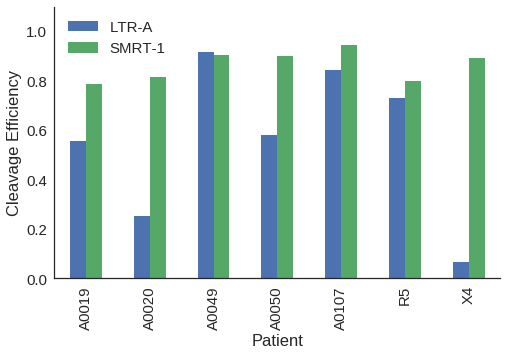

In [8]:
cleavage_efficiency = pd.pivot_table(cutting_data,
                                     index = 'Patient',
                                     columns = 'gRNA Name',
                                     values = 'Cleavage Efficiency',
                                     aggfunc = 'first')

fig, ax = plt.subplots(1,1, figsize = (8, 5))

cleavage_efficiency.plot(kind = 'bar', ax=ax)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Cleavage Efficiency')
ax.legend(loc = 'upper left')
sbn.despine(ax=ax)

Patient derived samples as well as consensus sequences from X4 and R5 viruses show different cleavage efficiencies based on the gRNA used. Cleavage efficiencies presented here are the average of 3 independant trials.

# Predicting cleavage efficiencies

Given the sequence of each target we can use the pre-built estimators to measure how much we would predict each clone to be cleaved.

In [13]:
ests = [('MIT', estimators.MITEstimator.build_pipeline()),
        ('CFD', estimators.CFDEstimator.build_pipeline()),
        ('Kinetic', estimators.KineticEstimator.build_pipeline())]

for name, est in ests:
    # Models only require the gRNA and Target sequence columns
    data = cutting_data[['gRNA Sequence', 'Target']].values
    cutting_data[name] = est.predict_proba(data)

view_cols = ['Patient', 'Clone', 
             'Target', 'gRNA Sequence', 
             'Cleavage Efficiency', 'MIT', 'CFD', 'Kinetic']

cutting_data[view_cols].head(n=10)

,Patient,Clone,Target,gRNA Sequence,Cleavage Efficiency,MIT,CFD,Kinetic
0,R5,1,ATCAGATATCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.729810,1.00000,1.000000,1.000000e+00
1,X4,1,ACCAGATATCCACTGTGCTTTGG,ATCAGATATCCACTGACCTT,0.064391,0.06622,0.000000,2.787364e-11
2,A0019,1,ACAAGATTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.555929,0.98600,0.318367,3.944447e-01
3,A0019,2,ACAAGATTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN,0.98600,0.318367,3.944447e-01
4,A0020,1,ACCAGATTTCCCCTGACCTTTGG,ATCAGATATCCACTGACCTT,0.253759,0.49200,0.096670,1.049108e-02
5,A0020,2,ACCAGATTTCCCCTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN,0.49200,0.096670,1.049108e-02
6,A0049,1,GTCAGATACCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.915590,0.61100,0.923077,4.699223e-01
7,A0049,2,GTCAGATACCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN,0.61100,0.923077,4.699223e-01
8,A0049,3,GTCAGATATCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,NaN,1.00000,1.000000,7.399999e-01
9,A0050,1,ACCAGGTTTCCACTGACCTTTGG,ATCAGATATCCACTGACCTT,0.580140,0.60500,0.262391,3.941518e-01


The table above shows the first 10 rows of data from the in vitro cleavage assay along with the predicted cleavage ability of spCas9.

In [6]:
# Rearrange data to match the shape of the observed values

predicted_cleavage = pd.pivot_table(cutting_data,
                                    index = 'Patient',
                                    columns = 'gRNA Name',
                                    values = ['MIT', 'CFD', 'Kinetic'],
                                    aggfunc = 'mean')
predicted_cleavage

CFD              Kinetic              MIT       
gRNA Name     LTR-A SMRT-1         LTR-A SMRT-1     LTR-A SMRT-1
Patient                                                         
A0019      0.318367    1.0  3.944447e-01    1.0  0.986000    1.0
A0020      0.096670    1.0  1.049108e-02    1.0  0.492000    1.0
A0049      0.948718    1.0  5.599482e-01    1.0  0.740667    1.0
A0050      0.262391    1.0  3.941518e-01    1.0  0.605000    1.0
A0107      0.877920    1.0  6.584140e-01    1.0  0.933741    1.0
R5         1.000000    1.0  1.000000e+00    1.0  1.000000    1.0
X4         0.000000    1.0  2.787364e-11    1.0  0.066220    1.0

The table above shows the mean value of the predicted cleavage efficiency for each clone in a sample. The data has been pivoted to match the shape of the known efficiency values.

# Evaluating predictions

Given a set of known cleavages as well as three methods of predicting cleavage we can evaluate which method is the most effective.

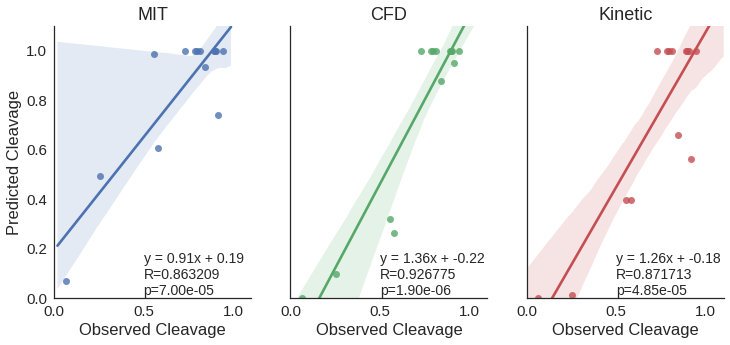

In [7]:
from scipy.stats import linregress

fig, axs = plt.subplots(1, 3, figsize = (12, 5), sharex= True, sharey=True)

observed_cleavage = cleavage_efficiency.values.flatten()

for (name, _), ax in zip(ests, axs.flatten()):
    
    pred_cleavage = predicted_cleavage[name].values.flatten()
    
    # Plot the observed vs predicted cleavage with bootstrapping
    sbn.regplot(observed_cleavage, pred_cleavage, ax=ax)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    ax.set_title(name)
    
    if ax.is_first_col():
        ax.set_ylabel('Predicted Cleavage')
    ax.set_xlabel('Observed Cleavage')
    
    # Make a linear regression model
    regress = linregress(observed_cleavage, pred_cleavage)
    out_str = 'y = %.02fx + %.02f\nR=%02f\np=%.02e' % (regress.slope, 
                                                       regress.intercept, 
                                                       regress.rvalue, 
                                                       regress.pvalue)
    
    ax.annotate(out_str, xy = (0.5, 0.0), 
                ha = 'left', va = 'bottom',
                fontsize = 14)
    
    sbn.despine(ax=ax)

The CFD model's predictions are the best match for the cleavage efficiency. However, due to the small number of samples caution should be used in interpretting these results directly.